Linear PLS R2: 0.9849477438297358


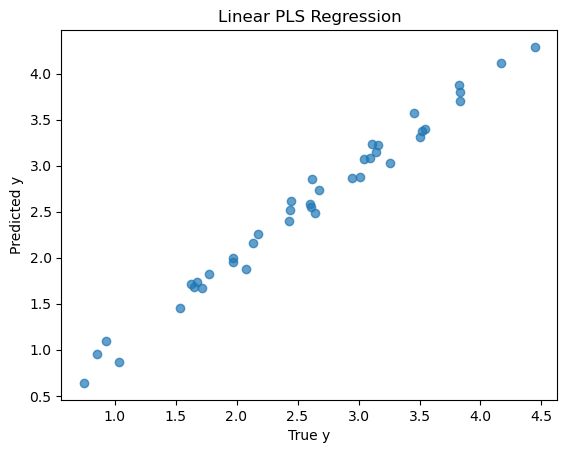

In [9]:
# Linear PLSR Example (skip this in class, but leave here as a demo?)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Synthetic linear data
np.random.seed(42)
X = np.random.rand(200, 5)
y = 3*X[:, 0] + 2*X[:, 1] + np.random.randn(200) * 0.1  # linear relation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

print("Linear PLS R2:", r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Linear PLS Regression")
plt.show()

# Non linear PLSR

**PLSR**:
* Step 1: Extracting latent variables that maximize covariance between predictors and responses.
* Step 2: Regressing the response on these latent variables (using least square approach).

**Linear PLSR** assumes linear relationship between predictors and responses.
* Latent variables as a linear combination of explanatory variables $LV = B*X$
* Regression model as a linear combination of the latent variables $Y = W*LV$ 

How to derive a regression model that captures non-linear relationships?

Linear PLS on nonlinear data - R2: 0.6400444436326829


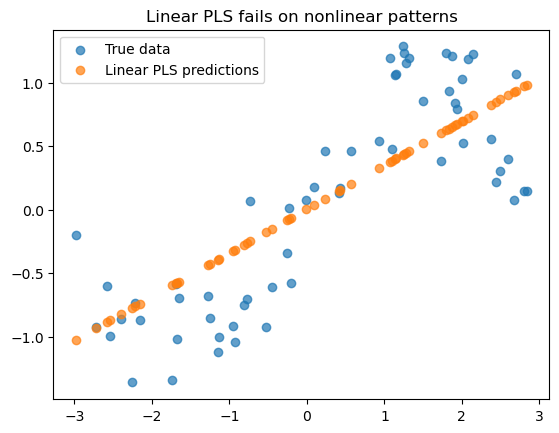

In [15]:
#Example where linear PLSR fail
# Synthetic non-linear data
np.random.seed(42)
X = np.linspace(-3, 3, 300).reshape(-1, 1)
y = np.sin(X).ravel() + 0.3*np.random.randn(300)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply linear PLS
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

print("Linear PLS on nonlinear data - R2:", r2_score(y_test, y_pred))

plt.scatter(X_test, y_test, label="True data", alpha=0.7)
plt.scatter(X_test, y_pred, label="Linear PLS predictions", alpha=0.7)
plt.legend()
plt.title("Linear PLS fails on nonlinear patterns")
plt.show()


## Introducing non-linearity in PLSR (by the use of one of 4 methods)

**1. Modifing the feature space before deriving latent variables**
* Method 1: Augment the predictor matrix with polynomial terms
* Method 2: Use Kernel functions to map the original data into higer dimensional feature space

**2. Derivation of latent variables**
* Unchanged to maintain the strenghts of PLSR 

**3. In derivation of regression model**
* Method 3: Use a spline function 
* Method 4: Use a NN to model the relationship between the latent variables and the responses

**Local Weighted PLSR**
* Applies PLSR locally around each prediction point using a weighted neighborhood.


## Step 1 (in non-linerar PLSR): Modifing the feature space before deriving latent variables

### Method 1: Augment the predictor matrix with polynomial terms
* Explicit creation of new features by adding terms such as $x_1^2, x_2^2, x_1 x_2, ...$
* Easier to interpret
* Not computationally effective 

also called "non-linear PLSR via input transformation"

### Method 2: Use Kernel functions $K(x_i, x_j)$
* Implicit projection of original data into higer-dimensional feature space
* More computationaly eficient for high dimensional expansions
* Harder to interpret

also called "Kernel PLSR".

Note: The PLSR algorithm is adapted to work with the kernel matrix K, which replaces the original X. Therefore the higher-dimensional feature space is not explicitly constructed!

Non-linear (Poly) PLS R2: 0.8713050762710719


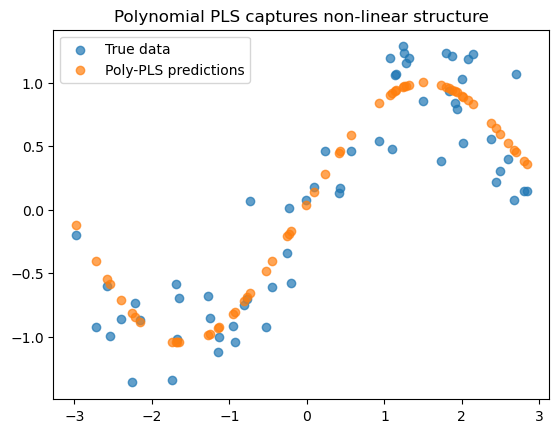

In [13]:
#Example method 2, can we add method 1 here as well?! Try add Kernal and show both in the same plot. Caroline! Try to find +/-

# Polynomial feature expansion
degree = 5
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

pls_poly = PLSRegression(n_components=degree) #degree should not be equal here, should have kernelPLS regression
pls_poly.fit(X_poly_train, y_train)
y_pred_poly = pls_poly.predict(X_poly_test)

print("Non-linear (Poly) PLS R2:", r2_score(y_test, y_pred_poly))

plt.scatter(X_test, y_test, label="True data", alpha=0.7)
plt.scatter(X_test, y_pred_poly, label="Poly-PLS predictions", alpha=0.7)
plt.legend()
plt.title("Polynomial PLS captures non-linear structure")
plt.show()

## Step 3 (in non-linerar PLSR): Derivation of a non-linear regression model

### Method 3: Use a spline function 
* Uses spline functions (e.g., B-splines) to model non-linear relationships between latent variables and response
* Requires knot selection and can be sensitive to overfitting
* Still has some level of interpretability

also called "Spline-based PLSR"

### Method 4: Use a NN to model the relationship between the latent variables and the responses
* Very flexible and powerful for modeling highly non-linear systems
* Requires careful training and regularization
* Interpretability is low

also called "NN-PLSR"

In [ ]:
#Insert example on NN. Eloise

## Derivation of a non-linear regression model (cont.)
Are we still using least square approach in non linear regression models? 

**Spline-based PLSR**: YES! The regression coefficients are estimated by minimizing the squared error between predicted and actual responses.

**NN-PLSR**: YES but not always. NN can use a least squares loss function (MSE loss), combined with a gradient descent optimization method.

## Local Weighted PLSR

Another form of non-linear PLSR that will be adressed by another group :) 

# Non-linear PLSR - A summary

1. Introduce non-linearity in the feature space before deriving latent variables

   Method 1: Augment the **predictor matrix with polynomial terms**

   Method 2: Use Kernel functions to **map the original data into higer dimensional feature space**
   
3. Introduce non-linearity in derivation of regression model

   Method 3: Use a **spline function**

   Method 4: Use a **NN to model the relationship** between the latent variables and the responses


Comment: This are some options, but more methods can be applied


In [ ]:
#Hilmi insert flow-chart as summary (or intro)